# General informations

In [ ]:
## CHA-AIPH Project
# -*- coding: utf-8 -*-

"""
Created on Tue Jan 4 2021
@author: Tisseaux Antoine

This script is used to create a proper dataframe from the eICU demo database 
available on physionet.org

the final dataframe will be used to predict survival at hospital discharge for
all patients admited in ICU 
"""

'\nCreated on Tue Jan 4 2021\n@author: Tisseaux Antoine\n\nThis script is used to create a proper dataframe from the eICU demo database \navailable on physionet.org\n\nthe final dataframe will be used to predict survival at hospital discharge for\nall patients admited in ICU \n'

# set environement

Importing packages

In [ ]:
# Importing libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

Importing files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



loading csv files

In [ ]:
apacheApsVar = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/project_submission_file_CHA_AIPH_Group1/data/initial_dataframes/apacheApsVar.csv', sep=",")
apachePredVar = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/project_submission_file_CHA_AIPH_Group1/data/initial_dataframes/apachePredVar.csv', sep=",")
patient = pd.read_csv('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/data/project_submission_file_CHA_AIPH_Group1/initial_dataframes/patient.csv', sep=",")

setting options for pandas

In [ ]:
# Displaying option: all columns
pd.set_option('display.max_columns', None)

# Data management 

## apacheApsVar:

In [ ]:
# replacing '-1' values in the dataframe because '-1' represent missing values 
# in apacheApsVar

apacheApsVar.replace(-1, np.nan, inplace=True)

# creating a new variable: 'glasgow' score from 'eyes', 
# 'motor' and 'verbal' assessement
glasgow = []
for i in range(len(apacheApsVar)):
    glasgow.append(apacheApsVar.iloc[i]['eyes'] + apacheApsVar.iloc[i]['motor'] 
                   + apacheApsVar.iloc[i]['verbal'])

apacheApsVar["glasgow"] = glasgow

# creating a subset for all interesting variables 
# of the apacheApsVar dataframe :
my_variables = ['patientunitstayid', 'intubated', 'vent', 'dialysis', 'wbc', 
                'temperature', 'respiratoryrate','heartrate', 'sodium', 
                'meanbp', 'ph', 'hematocrit', 'creatinine', 'albumin',
                'pao2', 'pco2','glucose', 'bilirubin', 'glasgow']

apacheApsVarSubset = apacheApsVar[my_variables]

## apachePredVar:

In [ ]:
# replacing '-1' values in the dataframe because '-1' represent missing values 
# in apachePredVar
apachePredVar.replace(-1, np.nan, inplace=True)

# creating a subset for all interesting variables of the apacheApsVar dataframe:

my_variables = ['patientunitstayid', 'gender', 'age', 'thrombolytics', 'aids', 
                'hepaticfailure', 'lymphoma', 'metastaticcancer', 'leukemia', 
                'immunosuppression', 'cirrhosis']

apachePredVarSubset = apachePredVar[my_variables]

## patient:

In [ ]:
# replacing empty strings '' values in the dataframe because '' represent 
# missing values in 'patient' dataframe
patient.replace("", np.nan, inplace=True)

# creating new variable for BMI from 'admissionheight' and 'admissionweight':
BMI = []
for i in range(len(patient)):
    if patient.iloc[i]['admissionweight'] != np.nan and patient.iloc[i]['admissionheight'] != np.nan:
        BMI.append(patient.iloc[i]['admissionweight']/((patient.iloc[i]['admissionheight']/100)**2))
patient['BMI'] = BMI

# creating binary outcome variable from 'hospitaldischargestatus' :
patient = pd.get_dummies(patient, prefix=['hospitaldischargestatus'], columns=['hospitaldischargestatus'])
patient['hospital_death'] = patient['hospitaldischargestatus_Expired']

# creating variable for patients with sepsis :
sepsis = []
for i in range(len(patient)):
    if "Sepsis" in str(patient.iloc[i]['apacheadmissiondx']):
      sepsis.append(1)
    else:
      sepsis.append(0)

patient['sepsis'] = sepsis

# creating a subset for all interesting variables of the apacheApsVar dataframe :
my_variables = ['patientunitstayid', 'patienthealthsystemstayid',
                'BMI', 'hospital_death', 'sepsis', 'ethnicity']

patientSubset = patient[my_variables]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


## Merging tables on patientunitstayid

In [ ]:
# merging tables on 'patientunitstayid' :
my_df_all_patients = pd.merge(apacheApsVarSubset, apachePredVarSubset)
my_df_all_patients = pd.merge(my_df_all_patients, patientSubset)

## Removing duplicates

removing duplicates on 'patienthealthsystemstayid" because we only want the initial prediction when the patient enter the ICU.

In [ ]:
# the duplicates with the smaller 'patientunitstayid' is removed
# the earliest unit admission is kept for analysis
# this is what we want because we need to make survival prediction from initial 
# ICU admission

my_df_all_patients.drop_duplicates(subset='patienthealthsystemstayid', inplace=True)

## Dropping variables which are not used for predection and analysis

In [ ]:
my_df_all_patients.drop(['patientunitstayid', 'patienthealthsystemstayid'], axis=1, inplace=True)

## Data visualization

Small visualization of the final dataset:

In [ ]:
print("\n\n10 first rows: \n")
my_df_all_patients.head(n=10)



10 first rows: 



,intubated,vent,dialysis,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,glucose,bilirubin,glasgow,gender,age,thrombolytics,aids,hepaticfailure,lymphoma,metastaticcancer,leukemia,immunosuppression,cirrhosis,BMI,hospital_death,sepsis,ethnicity
0,0,0,0,14.7,36.1,30.0,140.0,139.0,62.0,NaN,40.1,2.30,3.1,NaN,NaN,95.0,4.1,15.0,1.0,70.0,0,0,0,0,0,0,0,0,36.295906,1,0,Caucasian
1,0,0,0,NaN,36.4,16.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,52.0,0,0,0,0,0,0,0,0,20.575852,0,0,Caucasian
2,0,0,0,14.1,39.3,36.0,118.0,134.0,40.0,NaN,27.4,2.51,2.3,NaN,NaN,168.0,0.4,13.0,0.0,68.0,0,0,0,0,0,0,0,0,22.732803,0,1,Caucasian
3,0,0,0,NaN,NaN,25.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,0.0,71.0,0,0,0,0,0,0,0,0,38.617545,0,1,Caucasian
4,0,1,0,12.7,35.1,33.0,120.0,145.0,46.0,7.45,36.9,0.56,NaN,51.0,37.0,145.0,NaN,5.0,1.0,77.0,0,0,0,0,0,0,0,0,27.421875,0,0,Caucasian
5,0,0,0,NaN,36.7,37.0,102.0,NaN,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,25.0,0,0,0,0,0,0,0,0,31.952749,0,0,Caucasian
6,0,1,0,42.7,40.1,54.0,204.0,133.0,198.0,7.46,26.2,1.90,NaN,65.0,23.0,145.0,NaN,13.0,0.0,82.0,0,0,0,0,0,0,0,0,23.914007,0,1,Caucasian
7,0,1,0,NaN,36.4,32.0,57.0,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,NaN,0,0,0,0,0,0,0,0,35.078125,0,0,Caucasian
8,1,1,0,8.0,34.8,4.0,114.0,NaN,60.0,7.39,25.9,NaN,NaN,142.0,30.0,185.0,NaN,15.0,1.0,81.0,0,0,0,0,0,0,0,0,22.635548,0,0,Caucasian
9,0,0,0,4.1,37.2,10.0,114.0,142.0,62.0,NaN,31.0,0.65,NaN,NaN,NaN,121.0,NaN,15.0,0.0,59.0,0,0,0,0,0,0,0,0,28.392932,0,0,Caucasian


In [ ]:
print("table dimensions: \n", my_df_all_patients.shape)
print("\nnumber of patients: ", my_df_all_patients.shape[0])
print("\nnumber of variables: ", my_df_all_patients.shape[1])

table dimensions: 
 (160490, 32)

number of patients:  160490

number of variables:  32


In [ ]:
print("outcome count:\n")
my_df_all_patients['hospital_death'].value_counts()

outcome count:



0    146065
1     14425
Name: hospital_death, dtype: int64

In [ ]:
print("\n\ndata types: \n")
print(my_df_all_patients.info())



data types: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160490 entries, 0 to 171176
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   intubated          160490 non-null  int64  
 1   vent               160490 non-null  int64  
 2   dialysis           160490 non-null  int64  
 3   wbc                119786 non-null  float64
 4   temperature        149342 non-null  float64
 5   respiratoryrate    157628 non-null  float64
 6   heartrate          158365 non-null  float64
 7   sodium             126605 non-null  float64
 8   meanbp             157988 non-null  float64
 9   ph                 36169 non-null   float64
 10  hematocrit         123059 non-null  float64
 11  creatinine         126045 non-null  float64
 12  albumin            62801 non-null   float64
 13  pao2               36169 non-null   float64
 14  pco2               36169 non-null   float64
 15  glucose            139083 non-null 

## Converting data types

In [ ]:
# conversion into categories:
categorical_variables = ['vent', 'dialysis', 'intubated', 'gender', 'thrombolytics', 
                        'aids', 'hepaticfailure', 'lymphoma','metastaticcancer', 
                        'leukemia',  'immunosuppression', 'cirrhosis', 
                        'hospital_death', 'sepsis', 'ethnicity']

my_df_all_patients[categorical_variables] = my_df_all_patients[categorical_variables].astype('category')

# datatype:
print("\n\nverifying data types: \n")
print(my_df_all_patients.info())





verifying data types: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160490 entries, 0 to 171176
Data columns (total 32 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   intubated          160490 non-null  category
 1   vent               160490 non-null  category
 2   dialysis           160490 non-null  category
 3   wbc                119786 non-null  float64 
 4   temperature        149342 non-null  float64 
 5   respiratoryrate    157628 non-null  float64 
 6   heartrate          158365 non-null  float64 
 7   sodium             126605 non-null  float64 
 8   meanbp             157988 non-null  float64 
 9   ph                 36169 non-null   float64 
 10  hematocrit         123059 non-null  float64 
 11  creatinine         126045 non-null  float64 
 12  albumin            62801 non-null   float64 
 13  pao2               36169 non-null   float64 
 14  pco2               36169 non-null   float64 
 15  glucose 

## Aberrant values:

In [ ]:
print("descriptive statistics \n")
my_df_all_patients.describe()

descriptive statistics 



,wbc,temperature,respiratoryrate,heartrate,sodium,meanbp,ph,hematocrit,creatinine,albumin,pao2,pco2,glucose,bilirubin,glasgow,age,BMI
count,119786.000000,149342.00000,157628.000000,158365.000000,126605.000000,157988.000000,36169.000000,123059.000000,126045.000000,62801.000000,36169.000000,36169.000000,139083.000000,57022.000000,155801.000000,154668.000000,1.536170e+05
mean,12.225443,36.42682,25.231248,100.063379,137.965263,86.818595,7.353121,32.723066,1.545262,2.877927,130.507794,42.821348,163.602111,1.193878,13.013768,61.821178,inf
std,8.085599,0.93045,15.005593,30.989128,5.566824,41.678051,0.102181,6.897434,1.728813,0.692667,85.328980,13.388444,102.240055,2.351357,3.416545,16.857027,NaN
min,0.010000,20.00000,4.000000,20.000000,91.000000,40.000000,6.531000,6.000000,0.100000,1.000000,9.000000,6.500000,1.000000,0.100000,3.000000,0.000000,0.000000e+00
25%,7.400000,36.20000,11.000000,87.000000,135.000000,53.000000,7.302000,27.800000,0.710000,2.400000,76.000000,34.700000,97.000000,0.400000,13.000000,52.000000,2.347656e+01
50%,10.300000,36.50000,27.000000,104.000000,138.000000,66.000000,7.360000,32.800000,0.990000,2.900000,102.000000,40.600000,135.000000,0.670000,15.000000,64.000000,2.749748e+01
75%,15.200000,36.70000,36.000000,120.000000,141.000000,123.000000,7.420000,37.500000,1.600000,3.400000,153.000000,48.000000,199.000000,1.100000,15.000000,75.000000,3.286380e+01
max,198.100000,42.30000,60.000000,220.000000,195.000000,200.000000,7.810000,72.700000,24.950000,7.400000,636.000000,147.300000,2357.000000,60.200000,15.000000,89.000000,inf


### aberrant values for 'age':

In [ ]:
# Removing aberrant value for age:
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['age'] == 0], inplace=True)

age distribution with removed values

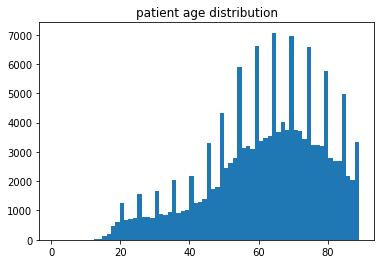

In [ ]:
plt.hist(my_df_all_patients['age'], bins=70)
plt.title("patient age distribution")
plt.show()

### aberrant values for BMI:

In [ ]:
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['BMI'] < 10], inplace=True)
my_df_all_patients.drop(my_df_all_patients.index[my_df_all_patients['BMI'] > 70], inplace=True)

BMI distribution with removed values:

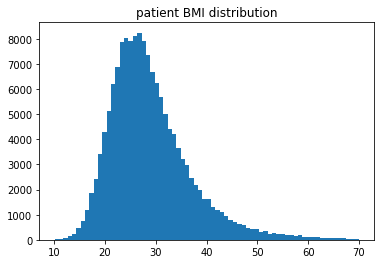

In [ ]:
plt.hist(my_df_all_patients['BMI'], bins=70)
plt.title("patient BMI distribution")
plt.show()

## Creating a subset with only sespis patients: 

In [ ]:
my_df_sepsis_patients = my_df_all_patients[my_df_all_patients['sepsis'] == 1]
my_df_sepsis_patients = my_df_sepsis_patients.dropna(subset=['apacheadmissiondx'])

num of patients after removing abberant values

In [ ]:
print(my_df_all_patients.shape)
print(my_df_sepsis_patients.shape)

(159436, 36)
(20476, 36)


## exporting non scaled dataframes

export all patients table

In [ ]:
# Write the DataFrame to CSV file.
with open('/content/drive/MyDrive/CHAIPH_PROJECT_GR2/project_submission_file_CHA_AIPH_Group1/data/final_dataframes/all_patients_raw_data.csv', 'w') as f:
  my_df_all_patients.to_csv(f)

export the sepsis patients table

In [ ]:
my_df_sepsis_patients.to_csv(r'/content/drive/MyDrive/CHAIPH_PROJECT_GR2/project_submission_file_CHA_AIPH_Group1/data/final_dataframes/sepsis_patients_raw_data.csv', header=True)